In [1212]:
# Librerie base
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt  
import seaborn as sns

# Modelli statistici
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Libreria ISLP (Statistical Learning)
from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

# Simple Linear Regression
We will use the Boston housing dataset, contained in the ISLP package. The Boston dataset records the medv (average house value) for 506 neighbourhoods around Boston.

In [1213]:
# carico il dataset e stampo l'head
car = pd.read_csv("CarPrice_Assignment.csv", encoding='utf-8')

In [1214]:
car.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [1215]:
#look at the first 5 rows in the datasets
car.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [1216]:
print(car.describe())

           car_ID   symboling   wheelbase   carlength    carwidth   carheight  \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   
mean   103.000000    0.834146   98.756585  174.049268   65.907805   53.724878   
std     59.322565    1.245307    6.021776   12.337289    2.145204    2.443522   
min      1.000000   -2.000000   86.600000  141.100000   60.300000   47.800000   
25%     52.000000    0.000000   94.500000  166.300000   64.100000   52.000000   
50%    103.000000    1.000000   97.000000  173.200000   65.500000   54.100000   
75%    154.000000    2.000000  102.400000  183.100000   66.900000   55.500000   
max    205.000000    3.000000  120.900000  208.100000   72.300000   59.800000   

        curbweight  enginesize   boreratio      stroke  compressionratio  \
count   205.000000  205.000000  205.000000  205.000000        205.000000   
mean   2555.565854  126.907317    3.329756    3.255415         10.142537   
std     520.680204   41.642693    0.270844

In [1217]:
# Controllo i dati nulli
columnsWithNulls=car.isnull().sum().sort_values(ascending=False)
columnsWithNulls=columnsWithNulls[columnsWithNulls>0]
print(columnsWithNulls)

Series([], dtype: int64)


Series([], dtype: float64)


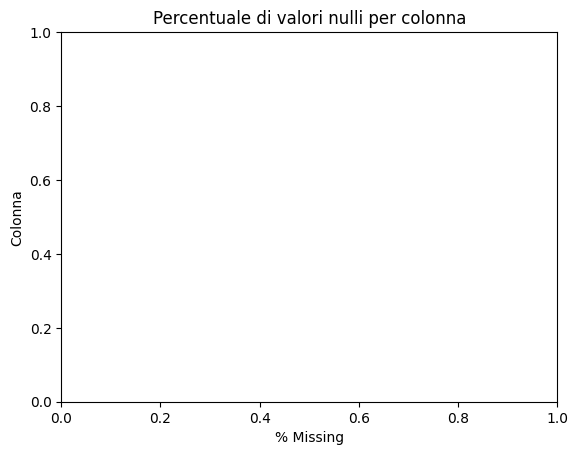

In [1218]:
# Controllo in percentuale quanti dati mancano così da capire come trattarli, pongo una soglia di eliminazione del regressore nel caso di +30% di dati mancanti
missing_pct = car.isnull().mean() * 100
missing_only = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_only)
sns.barplot(x=missing_only.values, y=missing_only.index)
plt.title('Percentuale di valori nulli per colonna')
plt.xlabel('% Missing')
plt.ylabel('Colonna')
plt.show()

In [1219]:
# 5. Droppa idcar
car.drop(columns=['car_ID'], inplace=True)

## Data processing

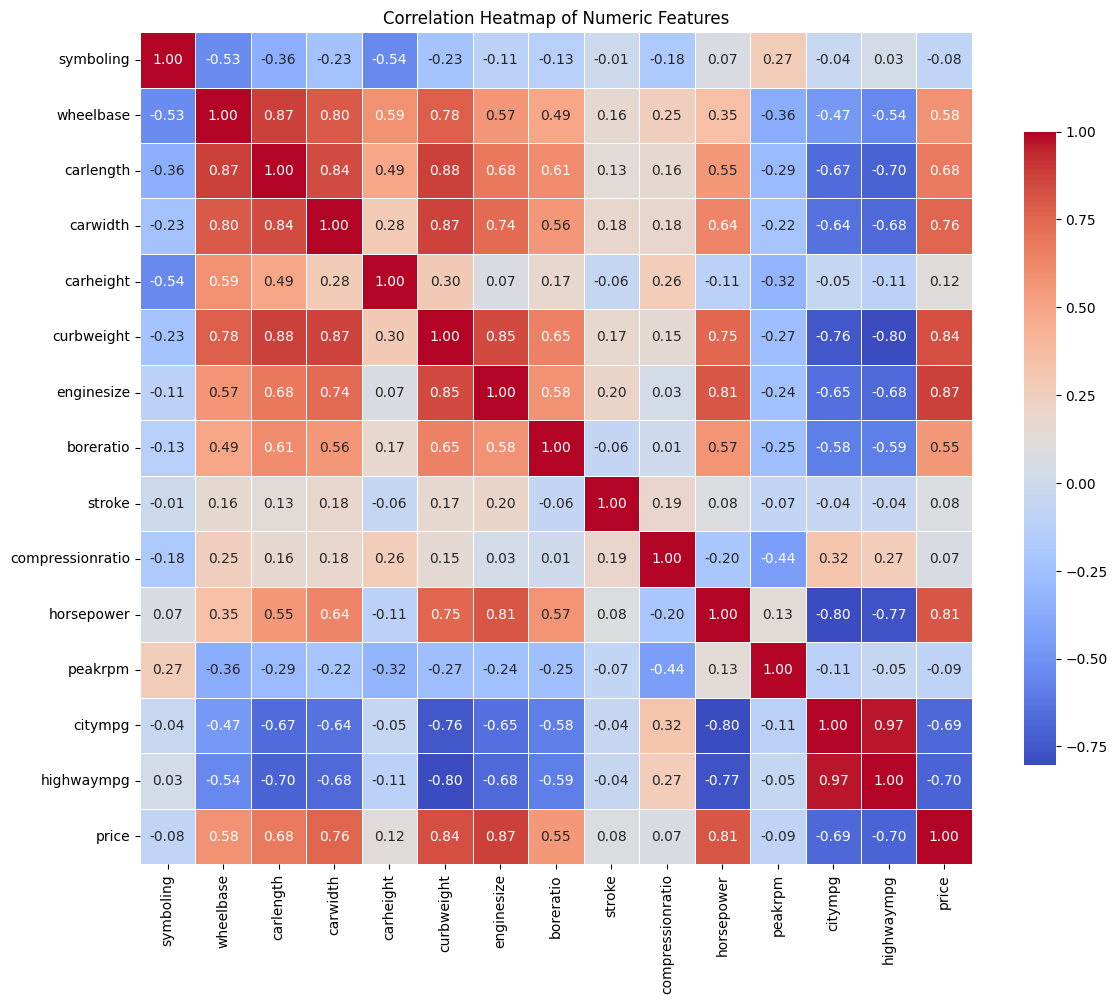

In [1220]:
# Seleziona le colonne numeriche
numeric_car = car.select_dtypes(include=[np.number])
# Controllo che ci siano almeno 4 variabili numeriche per evitare visualizzazioni poco utili
if numeric_car.shape[1] >= 4:
    # Calcola la matrice di correlazione
    corr = numeric_car.corr()
    
    # Imposta la figura
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .75}
    )
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')

### Decido di droppare una delle due var con correlazione > 0.90

In [1221]:
# 1. Seleziona solo le colonne numeriche e calcola la correlazione assoluta
corr = numeric_car.corr().abs()

# 2. Prendi la metà superiore (senza diagonale)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 3. Trova tutte le colonne con correlazione > 0.90
to_drop = upper.columns[upper.gt(0.90).any()].tolist()
print("Tutte le colonne candidate al drop:", to_drop)

# 4. Rimuovi 'Driver Aggression Score' dalla lista, se presente
to_drop = [col for col in to_drop if col != "price"]
print("Colonne da droppare (escl. price):", to_drop)

#magari potremmo fare un drop di chi ha un valore di correlazione > 0.90 ?????
# 5. Droppa le colonne selezionate
numeric_car.drop(columns=to_drop, inplace=True)
car.drop(columns=to_drop, inplace=True)
# 6. Controlla le colonne rimaste
print("Colonne rimaste dopo il drop:", car.columns.tolist())

Tutte le colonne candidate al drop: ['highwaympg']
Colonne da droppare (escl. price): ['highwaympg']
Colonne rimaste dopo il drop: ['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'price']


## Controllo il VIF

#### Controllo le statistiche descrittive prima di usare il VIF

In [1222]:
numerical_columns = car.select_dtypes(include=['float64', 'int64']).columns

# Visualizza le statistiche descrittive
print(car[numerical_columns].describe())

        symboling   wheelbase   carlength    carwidth   carheight  \
count  205.000000  205.000000  205.000000  205.000000  205.000000   
mean     0.834146   98.756585  174.049268   65.907805   53.724878   
std      1.245307    6.021776   12.337289    2.145204    2.443522   
min     -2.000000   86.600000  141.100000   60.300000   47.800000   
25%      0.000000   94.500000  166.300000   64.100000   52.000000   
50%      1.000000   97.000000  173.200000   65.500000   54.100000   
75%      2.000000  102.400000  183.100000   66.900000   55.500000   
max      3.000000  120.900000  208.100000   72.300000   59.800000   

        curbweight  enginesize   boreratio      stroke  compressionratio  \
count   205.000000  205.000000  205.000000  205.000000        205.000000   
mean   2555.565854  126.907317    3.329756    3.255415         10.142537   
std     520.680204   41.642693    0.270844    0.313597          3.972040   
min    1488.000000   61.000000    2.540000    2.070000          7.000000  

## Noto che sono su SCALE molto diverse

Il VIF (Variance Inflation Factor) misura quanto la varianza di una variabile indipendente è "inflazionata" a causa della collinearità con le altre variabili nel modello. Un VIF elevato indica che una variabile è altamente correlata con altre variabili indipendenti, il che potrebbe portare a problemi di multicollinearità nel modello di regressione.

Senza standardizzazione:
Se le variabili hanno scale molto diverse (ad esempio, price ha valori nell'ordine di decine di migliaia, mentre citympg è tra 10 e 50), la matrice di correlazione tra le variabili numeriche sarà dominata dalle variabili con valori più alti.

La presenza di una variabile come price, che ha valori molto più grandi rispetto ad altre variabili come citympg o horsepower, può causare un'instabilità numerica quando calcoli il VIF. In altre parole, le variabili con scale grandi potrebbero apparire artificialmente molto più correlate tra loro, e quindi il VIF può diventare molto alto, come nel caso del valore superiore a 5000 che hai osservato.

Con la standardizzazione:
La standardizzazione rende tutte le variabili numeriche comparabili, riducendo l'impatto delle differenze di scala. Quando le variabili hanno tutte la stessa media (0) e deviazione standard (1), le correlazioni tra di esse diventano più rappresentative della vera relazione tra le variabili e non sono distorte dalle differenze di grandezza.

Di conseguenza, il VIF diventa più stabile e interpretabile, come nel tuo caso in cui è sceso a circa 8, un valore che è generalmente accettabile. In pratica, un VIF superiore a 10 potrebbe essere motivo di preoccupazione, indicando una forte multicollinearità, ma un valore attorno a 8 suggerisce che non ci sono problemi gravi di collinearità.

Conclusioni:
Senza standardizzazione, le differenze di scala tra le variabili numeriche possono distorcere i risultati del VIF, portando a valori molto alti e quindi a un'interpretazione ingannevole.

Con la standardizzazione, il VIF diventa molto più stabile e ti dà un'indicazione più accurata della collinearità tra le variabili indipendenti. Un VIF di 8 è un valore ragionevole e suggerisce che non ci sono problemi gravi di multicollinearità nel tuo modello.

Quindi, il comportamento che hai osservato è perfettamente normale e conferma che la standardizzazione è fondamentale per ottenere risultati affidabili.

In [1223]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# --- PREPARAZIONE DATI ---
df = car.copy()
numeric_df = df.select_dtypes(include=[np.number])
target = 'price'
X = numeric_df.drop(columns=[target])
y = numeric_df[target]

# Normalizziamo per avere VIF più stabile
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# --- FUNZIONE VIF ---
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# --- FUNZIONE AUTOMATICA CON CORRELAZIONE ---
def remove_high_vif_features(X, y, threshold=10.0):
    X_current = X.copy()
    while True:
        vif_df = calculate_vif(X_current)
        max_vif = vif_df["VIF"].max()
        if max_vif <= threshold:
            break

        high_vif_features = vif_df[vif_df["VIF"] > threshold].copy()

        high_vif_features["corr_with_target"] = high_vif_features["feature"].apply(
            lambda f: abs(pd.Series(X_current[f]).corr(y))
        )

        high_vif_features.sort_values(by=["VIF", "corr_with_target"], ascending=[False, True], inplace=True)

        to_remove = high_vif_features.iloc[0]["feature"]
        print(f"Rimuovo '{to_remove}' | VIF: {high_vif_features.iloc[0]['VIF']:.2f} | Corr con price: {high_vif_features.iloc[0]['corr_with_target']:.3f}")
        X_current.drop(columns=[to_remove], inplace=True)

    print("\nVIF finale:")
    print(calculate_vif(X_current).sort_values("VIF", ascending=False))
    return X_current

# --- ESECUZIONE ---
X_finale_scaled = remove_high_vif_features(X_scaled, y)

# Ritorna alle scale originali (opzionale ma utile per interpretabilità)
X_finale = X[X_finale_scaled.columns]

# Ricostruzione del dataset finale
car = pd.concat([X_finale, y], axis=1)

Rimuovo 'curbweight' | VIF: 15.44 | Corr con price: 0.835

VIF finale:
             feature       VIF
2          carlength  8.624350
1          wheelbase  7.835482
9         horsepower  7.479038
5         enginesize  5.715009
3           carwidth  5.556374
11           citympg  5.436356
4          carheight  2.281876
6          boreratio  2.102195
10           peakrpm  1.983910
8   compressionratio  1.841941
0          symboling  1.838239
7             stroke  1.182059


E' stato usato StandardScaler  Per evitare problemi numerici o instabilità nei calcoli
Alcune variabili possono avere scale molto diverse: ad esempio, "prezzo" può essere nell’ordine di migliaia, mentre un rapporto o una percentuale può essere tra 0 e 1. Questo può influenzare le operazioni di inversione della matrice (che VIF fa internamente) e portare a risultati poco affidabili o incoerenti.

Per rendere il calcolo del VIF più stabile e interpretabile
Anche se il VIF è teoricamente invariante rispetto alla scala, nella pratica computazionale (con numeri finiti e floating point), standardizzare le variabili aiuta ad evitare che piccole variazioni numeriche causino grandi differenze nei VIF calcolati.

Per coerenza con modelli che richiedono scaling
Se in seguito andrai a usare modelli che richiedono scaling delle variabili (come regressione ridge, lasso, SVM, PCA...), avere già fatto lo scaling ti mantiene coerente tra analisi esplorativa e modellazione.

📌 In breve:

Senza Scaling	Con StandardScaler
Rischio di instabilità numerica se le scale sono molto diverse	Calcoli più stabili e coerenti
VIF può cambiare un po' a causa di errori numerici	VIF più robusto e comparabile


Nel contesto del calcolo del VIF, è fondamentale normalizzare i dati prima di calcolare il VIF per le seguenti ragioni:

Scala Differente: Le variabili numeriche possono avere scale molto diverse (ad esempio, una variabile potrebbe andare da 0 a 1000, mentre un'altra potrebbe variare da 0 a 1). Senza una normalizzazione, le variabili con una scala maggiore potrebbero sembrare più influenti nel modello, distorcendo i risultati.

Collinearità e VIF: La collinearità tra le variabili può essere influenzata dalla scala dei dati. Se le variabili non sono standardizzate, la presenza di variabili con una scala molto diversa potrebbe dare un VIF erroneamente alto o basso, distorcendo l'analisi.

Stabilità numerica: Quando si calcolano i VIF, avere variabili con unità diverse potrebbe portare a problemi numerici, riducendo la precisione del calcolo. Standardizzare i dati aiuta a evitare questi problemi e rende il calcolo del VIF più stabile.


In [1224]:
print(corr)


                  symboling  wheelbase  carlength  carwidth  carheight  \
symboling          1.000000   0.531954   0.357612  0.232919   0.541038   
wheelbase          0.531954   1.000000   0.874587  0.795144   0.589435   
carlength          0.357612   0.874587   1.000000  0.841118   0.491029   
carwidth           0.232919   0.795144   0.841118  1.000000   0.279210   
carheight          0.541038   0.589435   0.491029  0.279210   1.000000   
curbweight         0.227691   0.776386   0.877728  0.867032   0.295572   
enginesize         0.105790   0.569329   0.683360  0.735433   0.067149   
boreratio          0.130051   0.488750   0.606454  0.559150   0.171071   
stroke             0.008735   0.160959   0.129533  0.182942   0.055307   
compressionratio   0.178515   0.249786   0.158414  0.181129   0.261214   
horsepower         0.070873   0.353294   0.552623  0.640732   0.108802   
peakrpm            0.273606   0.360469   0.287242  0.220012   0.320411   
citympg            0.035823   0.470414

In [1225]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# --- PREPARAZIONE DATI ---
df = car.copy()  # Copia del dataframe
numeric_df = df.select_dtypes(include=[np.number])  # Seleziona solo colonne numeriche
target = 'price'  # Variabile target
X = numeric_df.drop(columns=[target])  # Caratteristiche (senza la colonna target)
y = numeric_df[target]  # Target (prezzo)

# Normalizziamo i dati per rendere il VIF più stabile
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# --- CALCOLO DEL VIF ---
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calcola il VIF per le variabili nel dataset
vif_df = calculate_vif(X_scaled)

# Mostra il risultato
print(vif_df.sort_values("VIF", ascending=False))

             feature       VIF
2          carlength  8.624350
1          wheelbase  7.835482
9         horsepower  7.479038
5         enginesize  5.715009
3           carwidth  5.556374
11           citympg  5.436356
4          carheight  2.281876
6          boreratio  2.102195
10           peakrpm  1.983910
8   compressionratio  1.841941
0          symboling  1.838239
7             stroke  1.182059


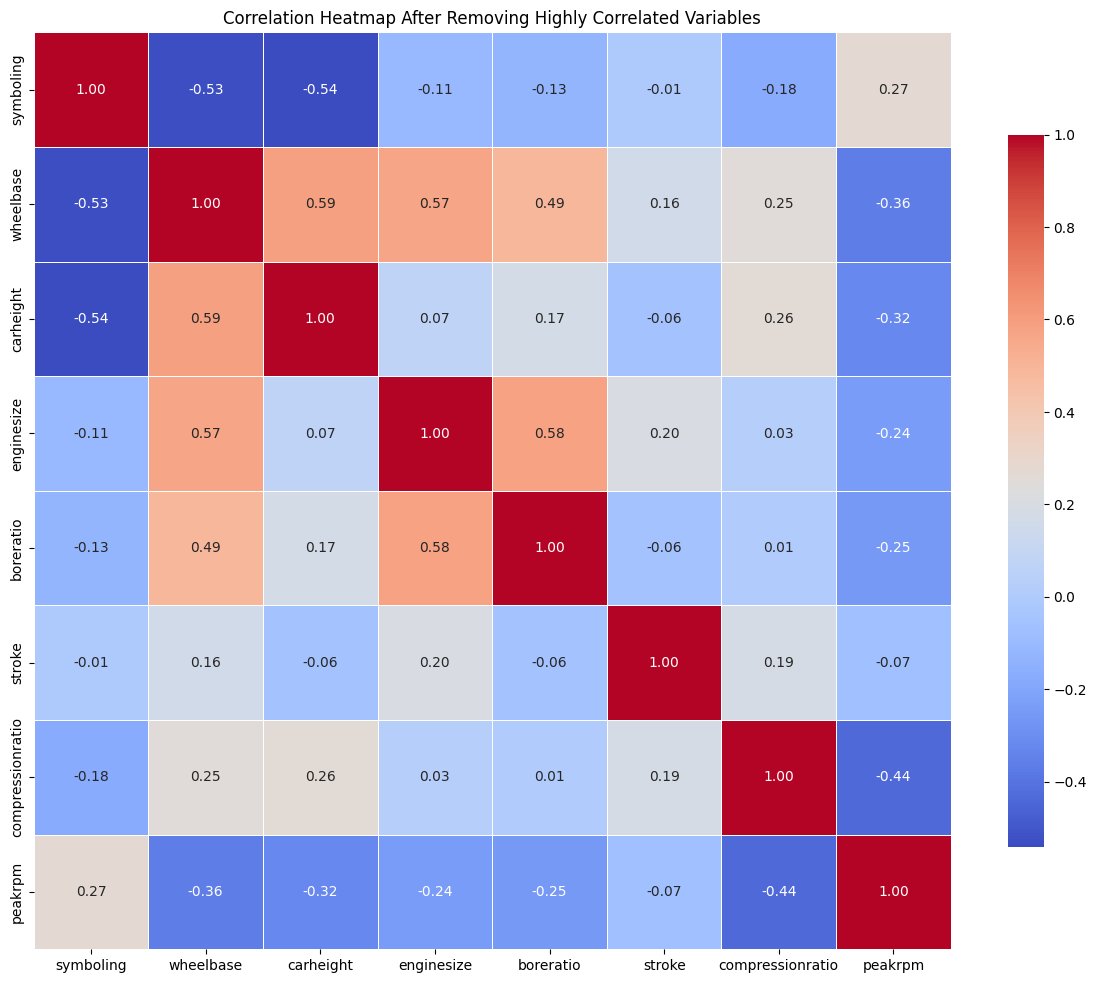

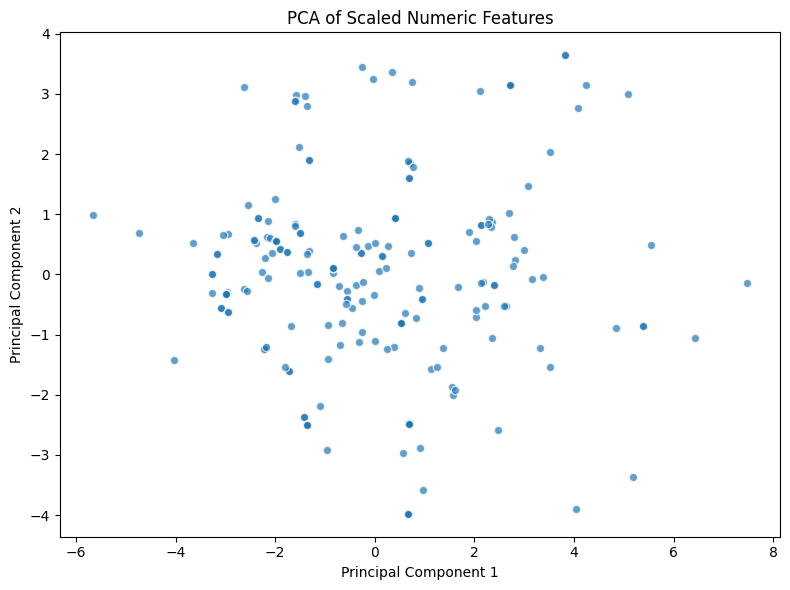

In [1226]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Seleziona le colonne numeriche (escludendo eventualmente il target se già presente)
numeric_car = car.select_dtypes(include=[np.number])
numeric_car = numeric_car.drop(columns=['price'], errors='ignore')  # esclude il target, se c'è

# Applica la StandardScaler
scaler = StandardScaler()
numeric_scaled = pd.DataFrame(scaler.fit_transform(numeric_car), columns=numeric_car.columns)

# Calcola la matrice di correlazione
corr = numeric_scaled.corr()

# Soglia di correlazione per rimuovere le variabili altamente correlate
threshold = 0.8

# Trova variabili altamente correlate
to_drop = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold:
            colname = corr.columns[i]
            to_drop.add(colname)

# Rimuove le colonne altamente correlate
numeric_scaled_reduced = numeric_scaled.drop(columns=to_drop)

# Visualizza la nuova matrice di correlazione
corr_reduced = numeric_scaled_reduced.corr()

# Imposta la figura per la heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_reduced,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .75}
)
plt.title('Correlation Heatmap After Removing Highly Correlated Variables')
plt.tight_layout()
plt.show()

# PCA per ridurre la dimensionalità
pca = PCA(n_components=2)  # Riduciamo a 2 componenti principali per semplicità
pca_result = pca.fit_transform(numeric_scaled)

# Creiamo un DataFrame con i componenti principali
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Visualizzazione dei dati dopo la PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, edgecolors='w', marker='o')
plt.title('PCA of Scaled Numeric Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [1227]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- SELEZIONE E SCALING DELLE VARIABILI NUMERICHE ---
numeric_car = car.select_dtypes(include=[np.number])
X = numeric_car.drop(columns=['price'], errors='ignore')  # Esclude il target

# Standardizzazione
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# --- CALCOLO DEL VIF ---
vif_data = pd.DataFrame({
    'feature': X_scaled.columns,
    'VIF': [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
})

# Ordina per VIF decrescente
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

# Stampa il risultato
print(vif_data)

             feature       VIF
0          carlength  8.624350
1          wheelbase  7.835482
2         horsepower  7.479038
3         enginesize  5.715009
4           carwidth  5.556374
5            citympg  5.436356
6          carheight  2.281876
7          boreratio  2.102195
8            peakrpm  1.983910
9   compressionratio  1.841941
10         symboling  1.838239
11            stroke  1.182059


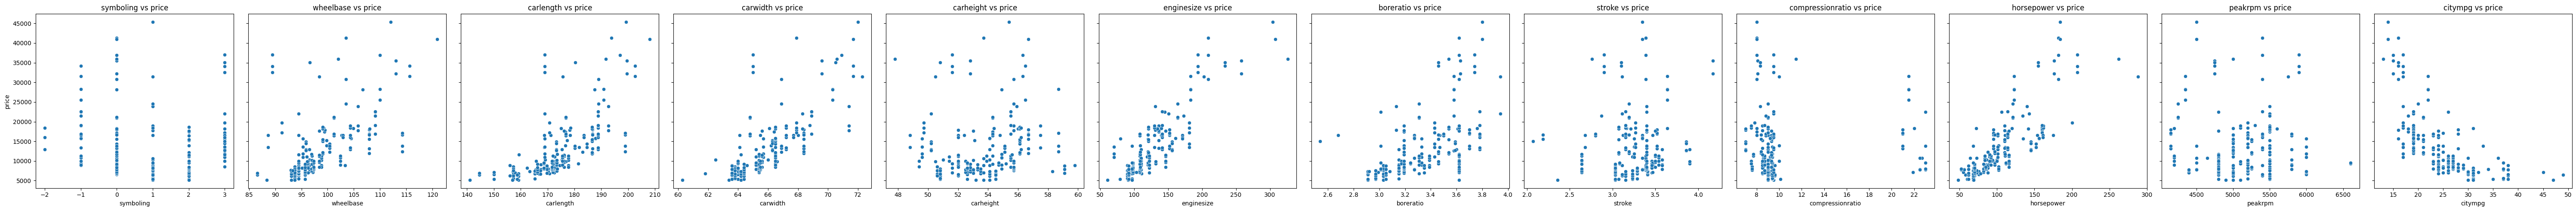

In [1228]:

x_vars = [col for col in numeric_car if col != 'price']

# Controlla se ci sono abbastanza variabili da visualizzare
n = len(x_vars)
if n > 0:
    # Imposta il layout della figura
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5), sharey=True)

    # Scatterplot di ogni variabile rispetto al Driver Aggression Score
    for i, var in enumerate(x_vars):
        sns.scatterplot(data=car, x=var, y='price', ax=axes[i])
        axes[i].set_title(f'{var} vs price')
        axes[i].set_xlabel(var)

    axes[0].set_ylabel('price')
    plt.tight_layout()
    plt.show()
else:
    print('Nessuna variabile numerica disponibile per il confronto con price')

## Linear model

In [1229]:
numeric_car = car.select_dtypes(include=[np.number])
numeric_car.drop(columns=['symboling'], inplace=True)

numeric_car

,wheelbase,carlength,carwidth,carheight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,price
0,88.6,168.8,64.1,48.8,130,3.47,2.68,9.0,111,5000,21,13495.0
1,88.6,168.8,64.1,48.8,130,3.47,2.68,9.0,111,5000,21,16500.0
2,94.5,171.2,65.5,52.4,152,2.68,3.47,9.0,154,5000,19,16500.0
3,99.8,176.6,66.2,54.3,109,3.19,3.40,10.0,102,5500,24,13950.0
4,99.4,176.6,66.4,54.3,136,3.19,3.40,8.0,115,5500,18,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...
200,109.1,188.8,68.9,55.5,141,3.78,3.15,9.5,114,5400,23,16845.0
201,109.1,188.8,68.8,55.5,141,3.78,3.15,8.7,160,5300,19,19045.0
202,109.1,188.8,68.9,55.5,173,3.58,2.87,8.8,134,5500,18,21485.0
203,109.1,188.8,68.9,55.5,145,3.01,3.40,23.0,106,4800,26,22470.0


### Ordering the 3 variables for the more promising

In [1230]:
# Target variable
target = 'price'

results = []

# Looping every possible variable
for col in numeric_car:
    X = sm.add_constant(car[[col]])
    y = car[target]
    
    model = sm.OLS(y, X).fit()
    
    results.append({
        'variable': col,
        'r_squared': model.rsquared,
        'p_value': model.pvalues[col]
    })

# Transforming data frame
results_df = pd.DataFrame(results)

# Ordering
top_r2_pval = results_df.sort_values(by='p_value', ascending=True).head(4)


# Output
print("VARIABILI CON R² PIU' ALTO E p-value PIU BASSO:")
print(top_r2_pval)


VARIABILI CON R² PIU' ALTO E p-value PIU BASSO:
      variable  r_squared       p_value
11       price   1.000000  0.000000e+00
4   enginesize   0.764129  1.354764e-65
8   horsepower   0.653088  1.483437e-48
2     carwidth   0.576575  9.627438e-40


### Fit Linear Model: mdev = b0 + b1*enginesize + e

In [1231]:
X = pd.DataFrame({'intercept': np.ones(car.shape[0]), 'enginesize': car['enginesize']})
X[:4]

,intercept,enginesize
0,1.0,130
1,1.0,130
2,1.0,152
3,1.0,109


In [1232]:
y = car[target]
model = sm.OLS(y, X) #function to fit a simple linear regression. Here we define the model
results = model.fit() #here we fit the model

In [1233]:
print(results.summary())

significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     657.6
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           1.35e-65
Time:                        18:53:37   Log-Likelihood:                -1984.4
No. Observations:                 205   AIC:                             3973.
Df Residuals:                     203   BIC:                             3979.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8005.4455    873.221     -9.168      0.0

### Creating the input matrix using ModelSpec of ISLP package

In [1234]:
model = MS(['enginesize'])
model = model.fit(car) 
X = model.transform(car)
X[:4]

,intercept,enginesize
0,1.0,130
1,1.0,130
2,1.0,152
3,1.0,109


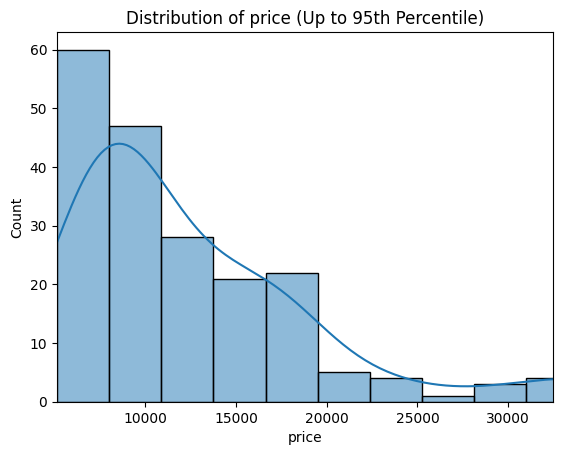

In [1235]:
sns.histplot(y, kde=True)

plt.xlim(y.quantile(0.00), y.quantile(0.95))

plt.title('Distribution of price (Up to 95th Percentile)')
plt.show()

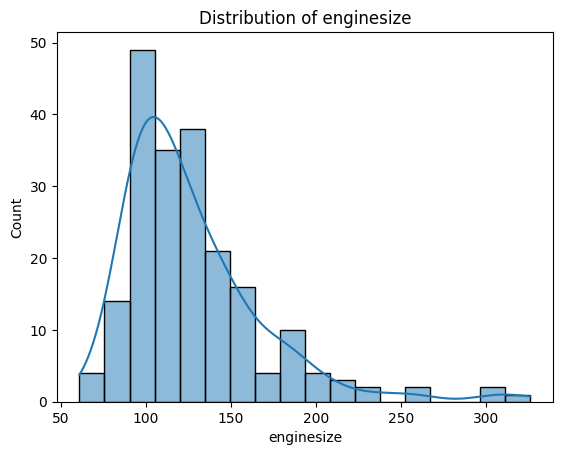

In [1236]:
sns.histplot(car['enginesize'], kde=True)


plt.title('Distribution of enginesize')
plt.show()

In [1237]:
# Get predictions on new input
new_df = pd.DataFrame({'enginesize': [130, 140, 170, 163, 157, 195]})
new_X = model.transform(new_df)  # Aggiungi una colonna di 1 per l'intercetta
new_X

,intercept,enginesize
0,1.0,130
1,1.0,140
2,1.0,170
3,1.0,163
4,1.0,157
5,1.0,195


In [1238]:
New_X = sm.add_constant(new_df)
new_predictions = results.get_prediction(new_X)
predicted_means = new_predictions.predicted_mean
print(predicted_means)

[13795.34859997 15472.3327639  20503.28525569 19329.39634094
 18323.20584258 24695.74566552]


In [1239]:
#Confidence interval
new_predictions.conf_int(alpha=0.05)

array([[13258.24642461, 14332.45077532],
       [14910.73969249, 16033.92583531],
       [19731.52762809, 21275.0428833 ],
       [18619.8483549 , 20038.94432698],
       [17661.81429087, 18984.5973943 ],
       [23667.28972852, 25724.20160252]])

In [1240]:
intercept = results.params.iloc[0]  # Intercetta (b)
slope = results.params.iloc[1]  # Pendenza (m)

formula = f"y = {slope:.4f} * enginesize + {intercept:.4f}"

print("FORMULA del modello di regressione:", formula)

FORMULA del modello di regressione: y = 167.6984 * enginesize + -8005.4455


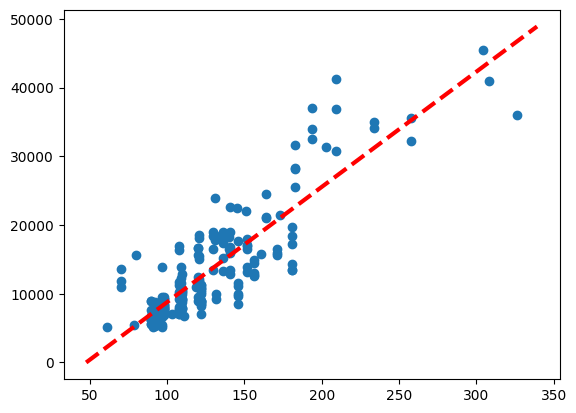

In [1241]:
def abline(ax, b, m, *args, **kwargs):
    "Aggiungi una retta con pendenza m e intercetta b su ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = plt.gca()
ax.scatter(car['enginesize'], car['price'])

abline(ax, intercept, slope, 'r--', linewidth=3)

plt.show()

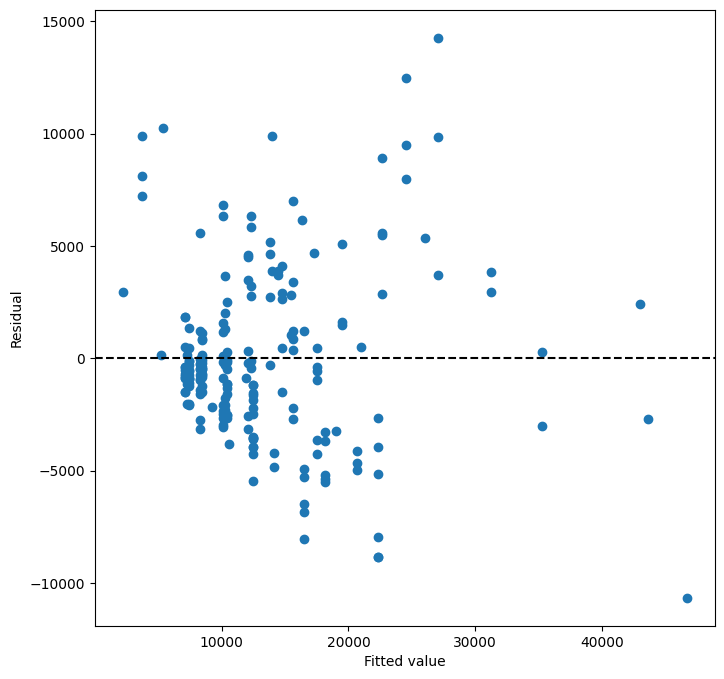

In [1242]:
# Diagnostics plot (We observe non linearity)
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.scatter(results.fittedvalues, results.resid)  # Scatter plot of fitted values vs residuals
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')  


49

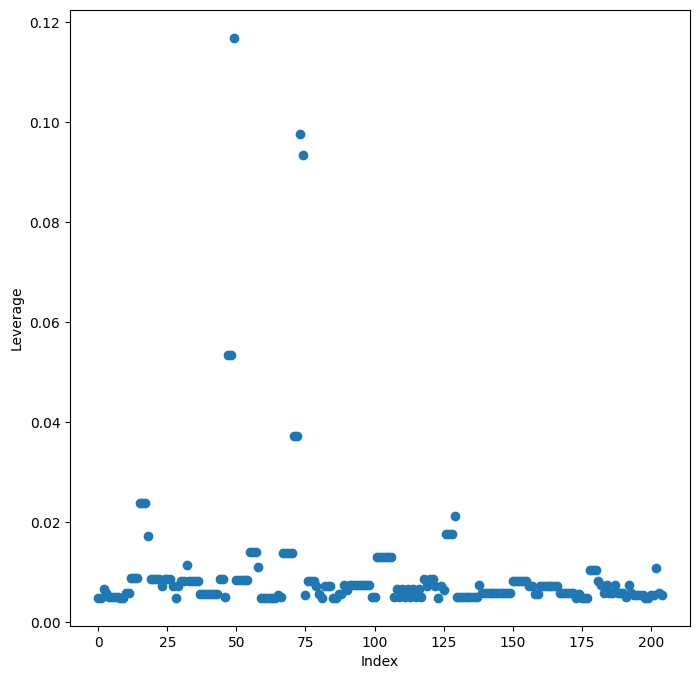

In [1243]:
# Compute leverage statistics
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

# Multiple Linear Regression

In [1244]:
# y = b*X + e (perform a regression using all of the predictors)
terms = numeric_car.drop(columns=['price'])
print(terms.columns)

Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'enginesize',
       'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm',
       'citympg'],
      dtype='object')


In [1245]:
X = MS(terms).fit_transform(car)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,-48370.0000,15000.000,-3.229,0.001
wheelbase,115.7188,95.916,1.206,0.229
carlength,-71.2408,53.181,-1.340,0.182
carwidth,546.5835,243.246,2.247,0.026
carheight,171.8811,135.477,1.269,0.206
enginesize,119.7512,12.822,9.339,0.000
boreratio,-958.4640,1196.013,-0.801,0.424
stroke,-2924.9681,774.264,-3.778,0.000
compressionratio,328.8358,75.724,4.343,0.000
horsepower,38.1242,15.399,2.476,0.014


In [1246]:
significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)


Variabili significative (p-value < 0.05):
intercept           1.460905e-03
carwidth            2.576982e-02
enginesize          2.394387e-17
stroke              2.107308e-04
compressionratio    2.272296e-05
horsepower          1.415397e-02
peakrpm             9.066709e-04
dtype: float64

Variabili insignificanti (p-value >= 0.05):
wheelbase    0.229116
carlength    0.181953
carheight    0.206071
boreratio    0.423896
citympg      0.051645
dtype: float64


In [1247]:
# getting goodness of fit
print("R2", results.rsquared)
print("RSE", np.sqrt(results.scale))

R2 0.8490345275300701
RSE 3191.241257745451


In [1248]:
minus_var = terms.drop(['wheelbase', 'carlength', 'carheight', 'boreratio', 'citympg'])
Xma = MS(minus_var).fit_transform(car)
model1 = sm.OLS(y, Xma)
results1 = model1.fit()
summarize(results1)

KeyError: "['wheelbase', 'carlength', 'carheight', 'boreratio', 'citympg'] not found in axis"

In [ ]:
significant_vars = results1.pvalues[results1.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results1.pvalues[results1.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)

In [ ]:
print("R2", results1.rsquared)
print("RSE", np.sqrt(results1.scale))

## Interaction Terms

In [ ]:
# to introduce and interactions terms use a python tuple
X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
summarize(model2.fit())

## Non-linear Transformations of the Predictors

In [ ]:
# poly() function present in the package ISLP specifies that columns representing polynomial functions of its first argument are added to the model matrix
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

## Qualitative predictors
Based on the Carseats dataset present in the package ISLP, will attempt to predict Sales (child car seat sales) in 400 locations based
on a number of predictors.

The Carseats data includes the qualitative predictor "ShelveLoc," which indicates the quality of the shelving location with three possible values: Bad, Medium, and Good.

In general for qualitative predictor the ModelSpec() generates one-hot encoding of the categorical variables automatically

In [ ]:
Carseats = load_data('Carseats')
Carseats.columns

In [ ]:
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
final = allvars + [('Income', 'Advertising'),
('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

# Cross Validation

### Validation set approach

In [ ]:
from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm #a wrapper that enables us to easily use the cross-validation tools of sklearn with models fit by statsmodels
from sklearn.model_selection import train_test_split

In [ ]:
Auto = load_data('Auto')
Auto_train , Auto_valid = train_test_split(Auto, test_size=196, random_state=0) # random_state is needed for reproducible result across run

In [ ]:
#fit a linear regression model
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train , X_train)
results = model.fit()

In [ ]:
# evaluate the model using the MSE on the validation data
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((y_valid - valid_pred)**2)

## Leave One-out Cross validation
The sklearn_sm() class takes a statsmodels model as its first argument. It also accepts two optional arguments: model_str for specifying a formula, and model_args, which is a dictionary containing additional arguments for fitting the model.

In [ ]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']

# This is a LOOCV because cv use the number of sample in our dataset, that is Auto.shape[0], making sure that each sample is use as a test set
cv_results = cross_validate(hp_model ,X, Y, cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

## K-Fold cross validation

In [ ]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(hp_model, X, Y, cv=kf)
cv_err = np.mean(cv_results['test_score'])
cv_err

# Exercise
Train and compare the performance of different cross-validation methods to identify the best model for polynomial regression with varying degrees using the Auto dataset.

https://scikit-learn.org/stable/

Fine